In [1]:
exclude_pids = [
    "65e5e9c2c0bfcbcbe835ec4d",
    "60fd64fd34ee5940500d499f",
    "61679f24fb77ff4978222991",
    "63fceba525d21052bc1ee390",
    "6526246367b37eef371ba914",
    "65798ffea5411209c86f31df",
    "65c630cc3824e0cf64dd2f7a",
    "615251a465f058e211cfbbb8",
    "5b197b8088ee7400012ae154",
    "5bad4db8b712f30001b87990",
    "5e6fd38fe95be7071b5196bf",
    "5fd79aba1833640f79ffd07d",
    "603421c858a3bd213d7c24b2",
    "604011377e5b121dc3267a3e",
    "60933bb6e47eb28c880b93d9",
    "613ad21e63b6c74708c223a9",
    "63bed6e176fba857a47fbaff",
    "63d54c4128bf8c671033ade4",
    "652da7c42cac6d10ff9de007",
    "65a6900704afb0a6f2f893d4",
    "65ba2af02a6a7f08d9e2b6c2",
    "660b812f113edc37de1df2b3",
    "6633381060353bc96809fc95",
    "660c87ac0012e87d84862040",
    "6414be45ec452483d7579868",
    "654e5bcb8cb6aeb8ca9b33a0",
    "661939712ce7ac67b60ab773",
    "5e2380c152e7a66358a276c5",
    "65086209d6edf5f2cf5f05d4",
    "6138df3f784ed068ae002cb3",
    "5d5035c5d87393001af70561",
    "614fe09fec9ce4a2a415476d",
    "5dd6dadf9c84d86703aa8615",
    "64528f4d51f889c0c30573af",
    "57ab3f8321e5a50001562cd3",
    "5ff39ec71d6cb49c6c906727",
    "603000ac19eaccdcf8b92e62",
    "61215755cea9b916eef0a38b"
]

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

df = pd.read_csv('raw_experiments.csv', index_col=0)
print(len(df))
df = df[~df.pid.isin(exclude_pids)]
print(len(df))
for col in df.columns:
    print(col)

1691
1542
experiment
human_role
map
pid
game_time
is_time_success
user number of utterances
user mean utterance length
user total number of tokens
user number of eng utterances
user number of es utterances
user number of mix utterances
user number of none utterances
user number of inter-sentential cs
user number of utterances with some ins switch
user number of total ins switches
user number of cong_masc switches
user number of cong_fem switches
user number of incong_masc switches
user number of incong_fem switches
user number of NP switches
user number of amb_masc switches
user number of amb_fem switches
user number of masc det switches
user number of fem det switches
user % entrainment - all dialog
user % entrainment - on bot inter-sentential cs
bot number of utterances
bot mean utterance length
bot total number of tokens
bot number of eng utterances
bot number of es utterances
bot number of mix utterances
bot number of none utterances
bot number of inter-sentential cs
bot number of 

In [3]:
alt_experiments = ['Alternation Baseline', 'Alternation Random CS', 'Alternation Short-context CS',
                   'Alternation Alignment CS', 'Alternation Adversarial CS']
ins_experiments = ['Insertional Spanish Baseline', 'Insertional Spanish Congruent','Insertional Spanish Masculine InCongruent',
                   'Insertional Spanish Feminine InCongruent']
global_exp_ =  'ins' #'ins' # 'alt'


experiments = ins_experiments if global_exp_ == 'ins' else alt_experiments
role = 'all' #'all' #'instructor' #'navigator'


In [4]:
def get_experiment_df(exp: list[str]):
    new_df = df[df['experiment'].isin(exp)]
    if role == 'all':
        return new_df
    return new_df[new_df['human_role'] == role]

def fix_lng_cols(text):
    if type(text) == float:
        return 'NONE'
    text = text.strip().lower()
    if text in ['english', 'enlgish', 'englis', 'eng']:
        return 'ENG'
    if text in ['spanish']:
        return 'ES'
    if 'eng' in text and 'spa' in text:
        return 'BOTH'
    if text in ['portuguese']:
        return 'NONE'
    else:
        return 'NONE'

def remove_rename_columns(df, remove=True):
    questions_rename = {'How much did you enjoy the task?' : 'Q_enjoy',
                        "How successful do you think you were at completing the task?" : 'Q_successful',
                        "How likely would you be to mix languages in the following contexts? Interacting with friends": "Q_mix_friends",
                        'Do you enjoy mixing languages in conversation?': "Q_enjoy_mix",
                        "How natural was your conversational partner’s language switching?": "Q_natural",
                        "On a day-to-day basis, how likely are you to have a conversation using both English and Spanish?": "Q_mix_often"
                       }
    if remove:
        remove_cols = ['human_role', 'experiment', 'map', 'pid']
        all_cols = list(df.columns)
        remove_cols.extend(list(filter(lambda x: 'bot_' in x, all_cols)))
        df = df.drop(remove_cols, axis=1)
    
    df = df.rename(columns=questions_rename, errors="raise")
    
    df["English %"] = df["user number of eng utterances"] / df["user number of utterances"] *100 
    df["None %"] = df["user number of none utterances"] / df["user number of utterances"] *100 
    df["Spanish %"] = df["user number of es utterances"] / df["user number of utterances"]  *100
    df["Mix %"] = df["user number of mix utterances"] / df["user number of utterances"]  *100
    
    df["Inter-Sentential CS %"] = df["user number of inter-sentential cs"] / (df["user number of utterances"] - 1)  *100

    df['% entrainment - on bot inter-sentential cs'] = df['user % entrainment - on bot inter-sentential cs'] * 100
    df['% entrainment - all dialog'] = df['user % entrainment - all dialog'] * 100

    # remove custom na
    if global_exp_ == 'ins':
        df = df.drop(df.loc[df['Q_natural'] == 'na'].index)
        df = df.drop(df.loc[df['Q_mix_often'] == 'na'].index)

    df = df.drop(df.loc[df['Q_mix_friends'] == 'na'].index)
    df = df.drop(df.loc[df['Q_enjoy_mix'] == 'na'].index)


    df['Q_mix_friends'] = df['Q_mix_friends'].astype(int)
    df['Q_enjoy_mix'] = df['Q_enjoy_mix'].astype(int)

    if global_exp_ == 'ins':
        df['Q_natural'] = df['Q_natural'].astype(int)
        df['Q_mix_often'] = df['Q_mix_often'].astype(int)


    
    df['lng_1'] = df['Enter your native language, or the language you are providing answers for, here:'].apply(fix_lng_cols)
    df['lng_2'] = df['Enter your most proficient second language here:'].apply(fix_lng_cols)
        
    
    return df


In [5]:
def plot_corr_matt(df, title):
    f = plt.figure(figsize=(15, 15))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title(f'{title} - Correlation Matrix', fontsize=16)

    
def plot_2d_scatter(df, title, x, y, color, size):
    print(df.shape)
    fig = px.scatter(df, x=x, y=y, color=color, size=size, title=title)
    fig.show()

In [6]:
df_copy = get_experiment_df(experiments)
df_copy = remove_rename_columns(df_copy, False)
print(df_copy.shape)

(640, 128)


Filter switchers?

In [7]:
# df_copy = df_copy[df_copy['Q_mix_often'] >= 50]
# df_copy = df_copy[df_copy['Mix %'] > 0]
# df_copy.shape

bot number of cong_masc switches - 143 participants, 388 chats, 1458 switches
human_role
navigator     221
instructor    167
Name: count, dtype: int64


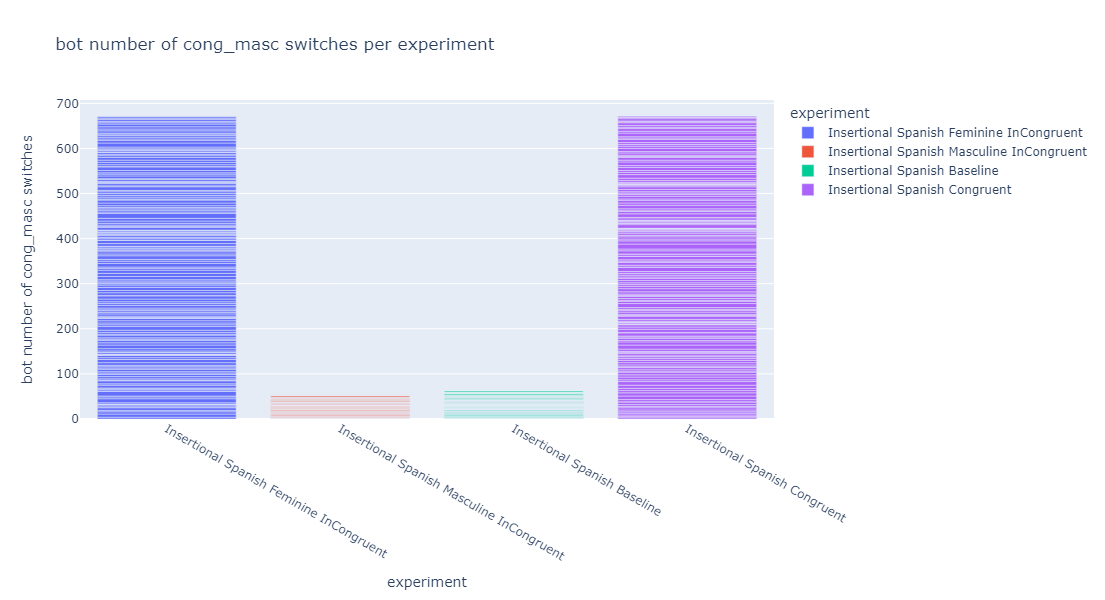

In [8]:
y_ = 'user number of incong_masc switches'
# y_ = 'user number of incong_fem switches'

# y_ = 'user number of cong_fem switches'
# y_ = 'user number of cong_masc switches'
# y_ = 'user number of amb_fem switches'
# y_ = 'user number of amb_masc switches'
# y_ = 'user number of NP switches'

# validate bot
y_ = 'bot number of incong_masc switches'
# y_ = 'bot number of incong_fem switches'
# y_ = 'bot number of cong_fem switches'
y_ = 'bot number of cong_masc switches'


df_test = df_copy[df_copy[y_] > 0]
num_chats = df_test.shape[0]
num_partcipiants = len(df_test['pid'].unique())
num_swtiches = sum(df_test[y_])
print(f'{y_} - {num_partcipiants} participants, {num_chats} chats, {num_swtiches} switches')
print(df_test['human_role'].value_counts())

fig = px.bar(df_copy,
             x='experiment',
             y=y_,
             color='experiment',
             title=f"{y_} per experiment",
             width=1000, height=600
            ).show()


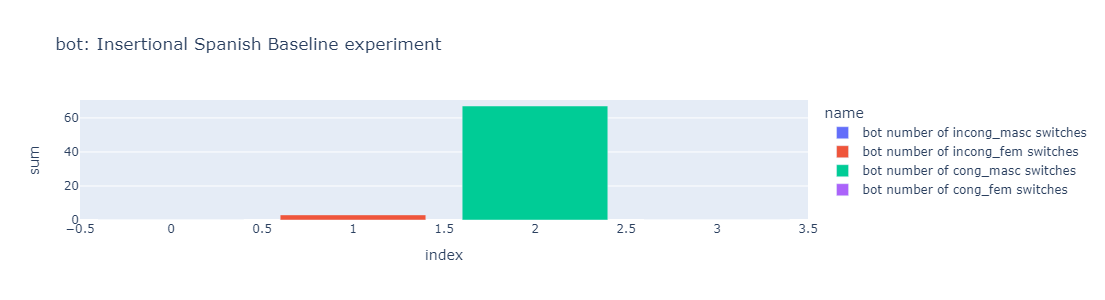

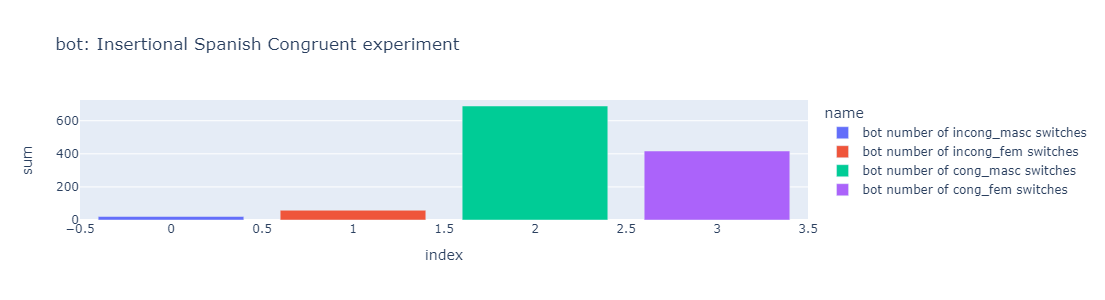

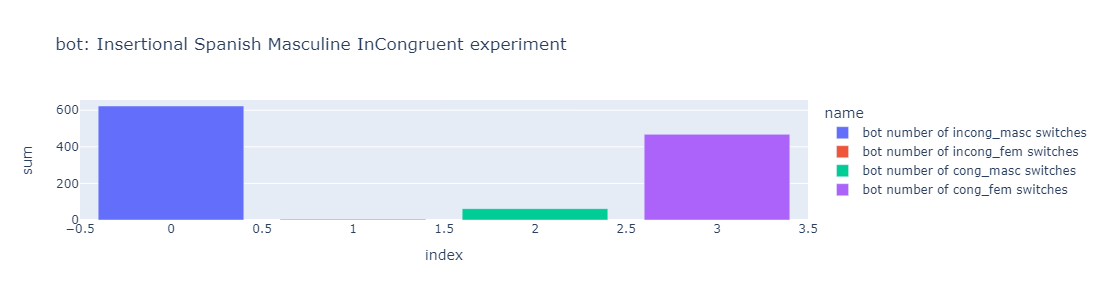

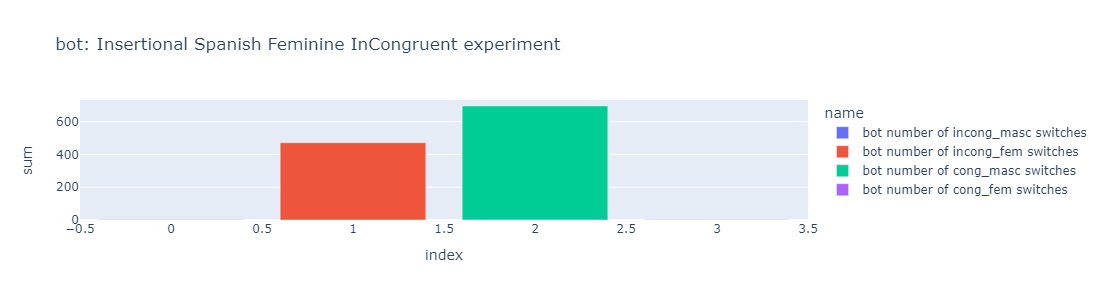

In [9]:
for exp in experiments:
    exp_df = get_experiment_df([exp])

    features = [
                'bot number of incong_masc switches',
                'bot number of incong_fem switches', 
                'bot number of cong_masc switches',
                'bot number of cong_fem switches'
                 ]
    sums_ = []
    for f in features:
        sums_.append(sum(exp_df[f]))
    
    tmp_df = pd.DataFrame({'sum':sums_, 'name':features})

    tmp_df = pd.DataFrame.from_dict({'sum':sums_, 'name':features})
    fig = px.bar(tmp_df,
                 y='sum',
                 color='name',
                 title=f"bot: {exp} experiment",
                 width=600, height=300).show()


In [27]:
exp_idx = 1
print(experiments[exp_idx])
exp_df = get_experiment_df([experiments[exp_idx]])

y_ = 'bot number of incong_masc switches'
# y_ = 'bot number of incong_fem switches'
# y_ = 'bot number of cong_fem switches'
# y_ = 'bot number of cong_masc switches'

df_test = exp_df[exp_df[y_] > 0]

num_chats = df_test.shape[0]
num_partcipiants = len(df_test['pid'].unique())
num_swtiches = sum(df_test[y_])
print(f'{y_} - {num_partcipiants} participants, {num_chats} chats, {num_swtiches} switches')
print(df_test['human_role'].value_counts())

df_test

Insertional Spanish Congruent
bot number of incong_masc switches - 12 participants, 12 chats, 21 switches
human_role
instructor    6
navigator     6
Name: count, dtype: int64


experiment  human_role  map  \
316   Insertional Spanish Congruent  instructor    2   
384   Insertional Spanish Congruent  instructor    2   
387   Insertional Spanish Congruent   navigator    1   
537   Insertional Spanish Congruent   navigator    1   
992   Insertional Spanish Congruent   navigator    3   
1188  Insertional Spanish Congruent   navigator    1   
1228  Insertional Spanish Congruent   navigator    1   
1240  Insertional Spanish Congruent   navigator    1   
1281  Insertional Spanish Congruent  instructor    2   
1289  Insertional Spanish Congruent  instructor    2   
1301  Insertional Spanish Congruent  instructor    2   
1325  Insertional Spanish Congruent  instructor    2   

                           pid  game_time  is_time_success  \
316   5eaf585e8a9edb65a576c008        210                1   
384   5f173b90cea174080152310b        406                1   
387   5f1b4845cbf55f3192e33b89        420                0   
537   60cffac73993c4347f897f1a        231                1   
992   6516f3b04e4b027feb50870a        277                1   
1188  6579bdb995e28b4809d89d03        420                0   
1228  659a0d020c80c3b946e05be7        321                1   
1240  65a3c07a4b379f4cebea4e65        420                0   
1281  65b1f4f944151066f1ca83e6        420                0   
1289  65b3dbe69408db7fa834835d        420                0   
1301  65b7df79bd16de5cd6a3a12b        180                1   
1325  65bdaa4842494ba9f82fac54        381                1   

      user number of utterances  user mean utterance length  \
316                           8                    7.750000   
384                           9                   11.000000   
387                          10                    6.000000   
537                          12                    3.333333   
992                          10                    3.800000   
1188                          9                    2.000000   
1228                         13                    3.923077   
1240                         11                    4.636364   
1281                          5                   19.800000   
1289                          3                    4.666667   
1301                          5                   16.000000   
1325                          5                   18.800000   

      user total number of tokens  user number of eng utterances  ...  \
316                            62                              0  ...   
384                            99                              1  ...   
387                            60                              7  ...   
537                            40                              0  ...   
992                            38                              1  ...   
1188                           18                              0  ...   
1228                           51                              0  ...   
1240                           51                             11  ...   
1281                           99                              0  ...   
1289                           14                              0  ...   
1301                           80                              0  ...   
1325                           94                              0  ...   

      dist_score  Place of birth:  Place of current residence:  \
316          NaN              NaN                          NaN   
384          NaN              NaN                          NaN   
387     3.724638              NaN                          NaN   
537     1.231884              NaN                          NaN   
992     1.960000              NaN                          NaN   
1188    4.173913              NaN                          NaN   
1228    0.724638              NaN                          NaN   
1240    7.275362              NaN                          NaN   
1281         NaN              NaN                          NaN   
1289         NaN              NaN                          

In [11]:
# df_corr = get_experiment_df(experiments)
# df_corr = remove_rename_columns(df_corr, True)
# df_corr.corr()

(640, 128)


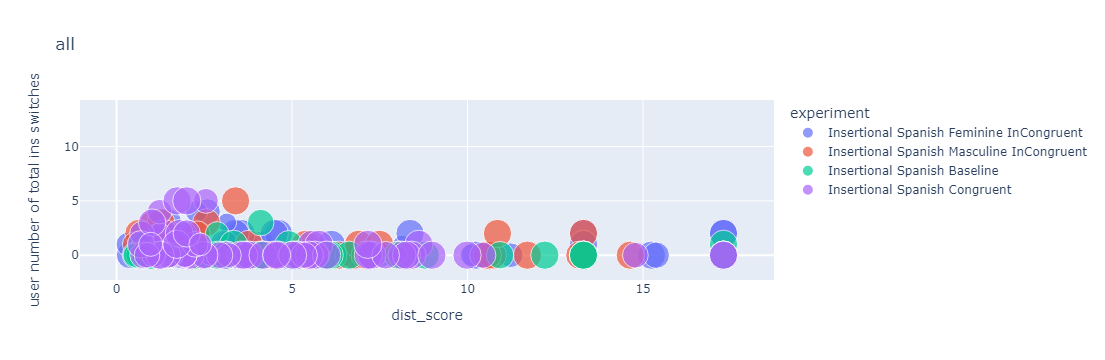

(640, 128)


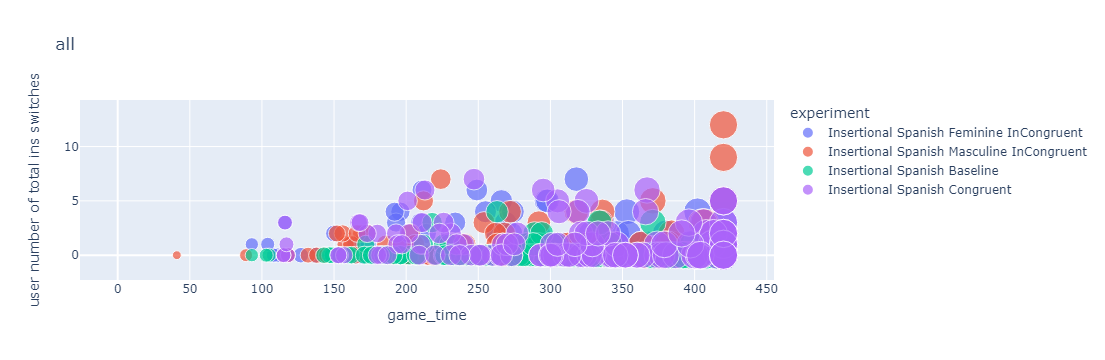

(640, 128)


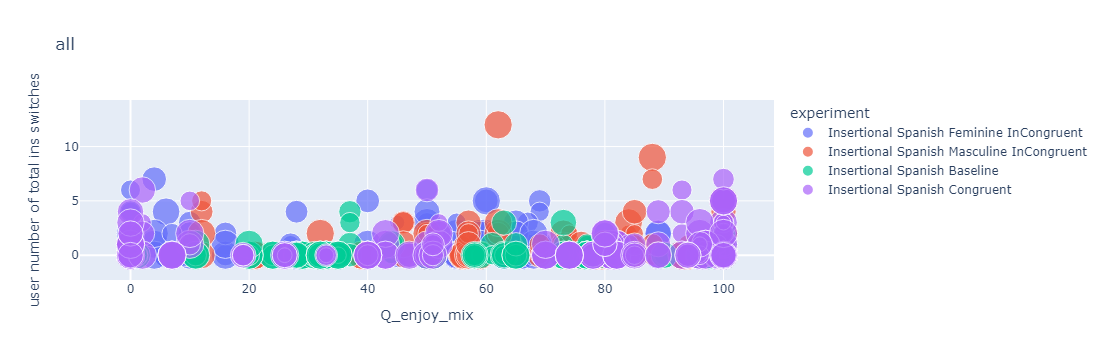

(640, 128)


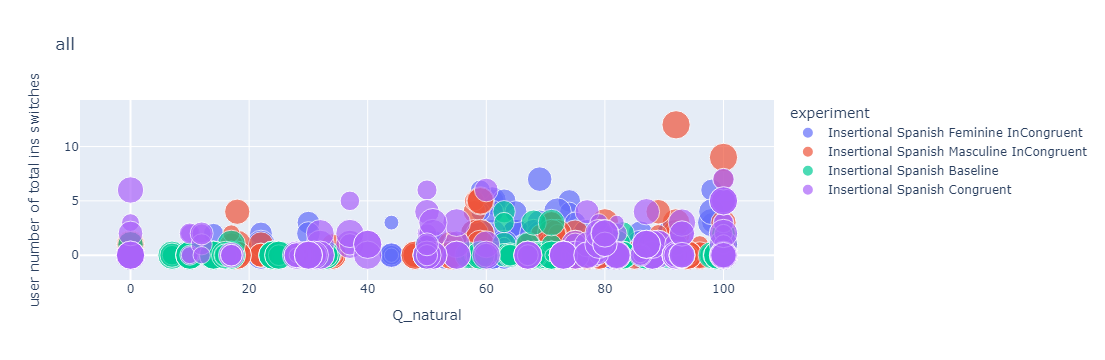

(640, 128)


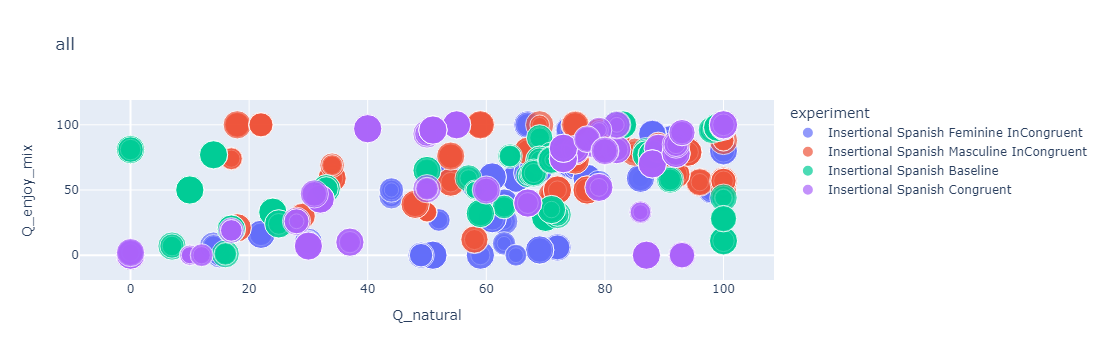

In [12]:


y = 'user number of total ins switches'
# y = "user number of utterances with some ins switch"
# y = 'user number of incong_fem switches'

# plot_2d_scatter(df=df_copy,
#         x="Q_mix_often",
#         y=y,
#         color='experiment',
#         size='game_time',
#         title=f'{role}')

# plot_2d_scatter(df=df_copy,
#         x="Q_mix_often",
#         y="Mix %",
#         color='experiment',
#         size='game_time',
#         title=f'{role}')

# plot_2d_scatter(df=df_copy,
#         x="Q_mix_often",
#         y="Q_natural",
#         color='experiment',
#         size='game_time',
#         title=f'{role}')

# plot_2d_scatter(df=df_copy,
#         x="Q_successful",
#         y=y,
#         color='experiment',
#         size='game_time',
#         title=f'{role}')

plot_2d_scatter(df=df_copy,
        x="dist_score",
        y=y,
        color='experiment',
        size='game_time',
        title=f'{role}')

plot_2d_scatter(df=df_copy,
        x="game_time",
        y=y,
        color='experiment',
        size='game_time',
        title=f'{role}')

plot_2d_scatter(df=df_copy,
        x="Q_enjoy_mix",
        y=y,
        color='experiment',
        size='game_time',
        title=f'{role}')

plot_2d_scatter(df=df_copy,
        x="Q_natural",
        y=y,
        color='experiment',
        size='game_time',
        title=f'{role}')


plot_2d_scatter(df=df_copy,
        x="Q_natural",
        y="Q_enjoy_mix",
        color='experiment',
        size='game_time',
        title=f'{role}')




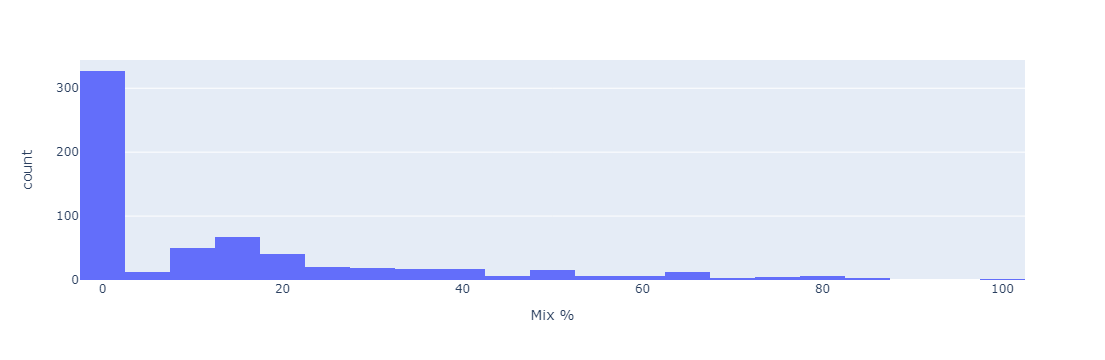

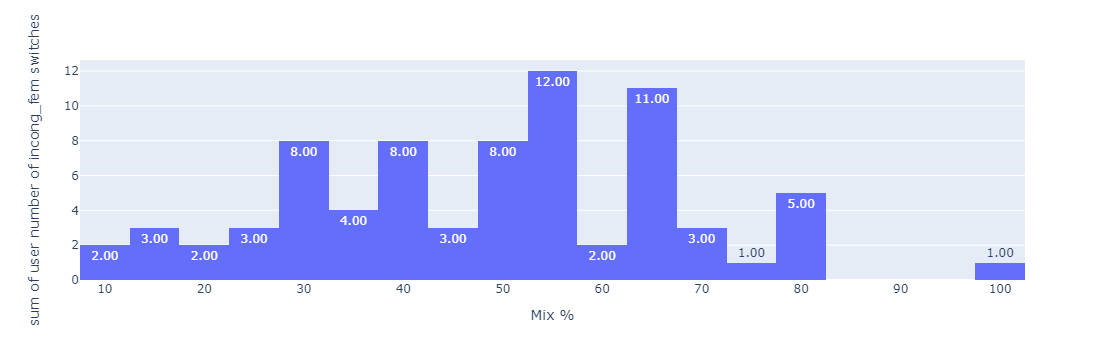

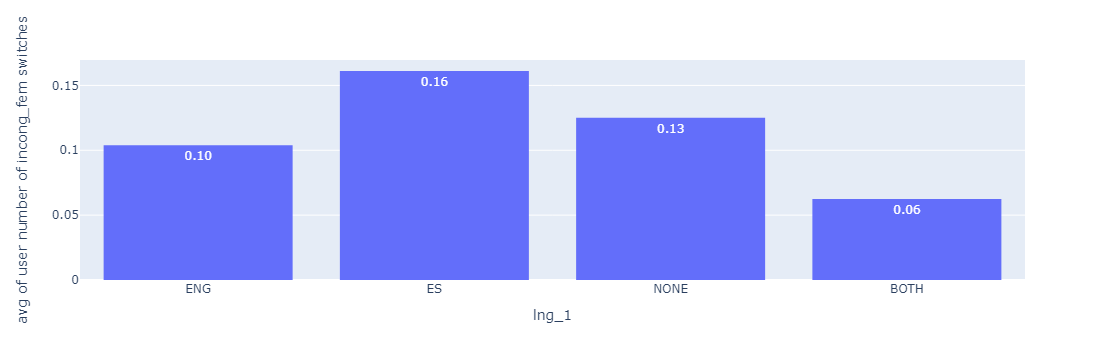

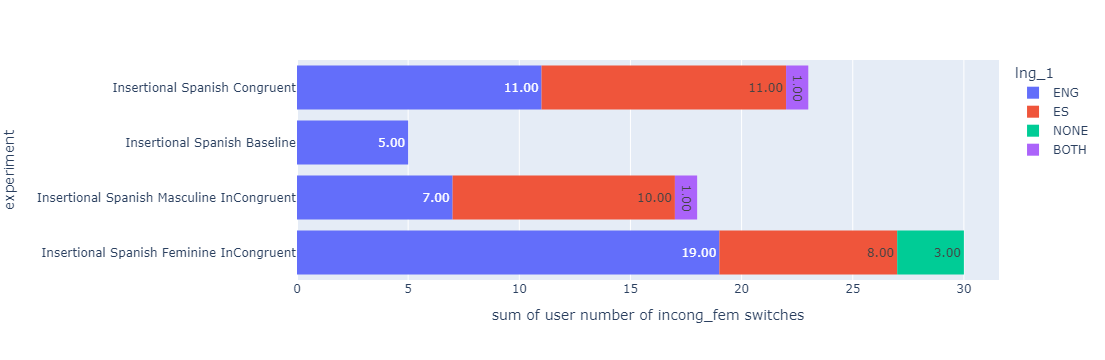

In [13]:
y = 'user number of incong_fem switches'
# y = 'user number of total ins switches'
# y = "user number of utterances with some ins switch"
# y = 'Mix %'
# y = 'Inter-Sentential CS %'


px.histogram(df_copy,  x='Mix %').show()

px.histogram(df_copy,
             y=y,
             x='Mix %',  #Q_enjoy_mix #Q_mix_often
             # color='experiment',
             text_auto='.2f',
             # histfunc='avg',
            ).update_xaxes(categoryorder="array",categoryarray=list(range(100))).show()

px.histogram(df_copy,
             y=y,
             x='lng_1',  #Q_enjoy_mix #Q_mix_often
             # color='experiment',
             text_auto='.2f',
             histfunc='avg',
            ).show()

px.histogram(df_copy,
             x=y,
             y='experiment',
             color='lng_1',
             text_auto='.2f',
             # histfunc='avg',
            ).show()

In [14]:
df_copy.shape

(640, 128)

In [15]:
df_copy['Enter your native language, or the language you are providing answers for, here:'].value_counts() / 4

Enter your native language, or the language you are providing answers for, here:
English                                            73.0
Spanish                                            36.0
english                                            21.0
English                                             6.0
spanish                                             6.0
Spanish                                             2.0
SPANISH/ENGLISH                                     1.0
Spanish and English                                 1.0
Spanish, English                                    1.0
ENGLISH                                             1.0
spanish                                             1.0
English, Spanish                                    1.0
spanish and english                                 1.0
engish                                              1.0
english,spanish                                     1.0
espanol                                             1.0
Espanol                

In [16]:
df_copy['lng_1'].value_counts()/4

lng_1
ENG     101.0
ES       45.0
BOTH      8.0
NONE      6.0
Name: count, dtype: float64

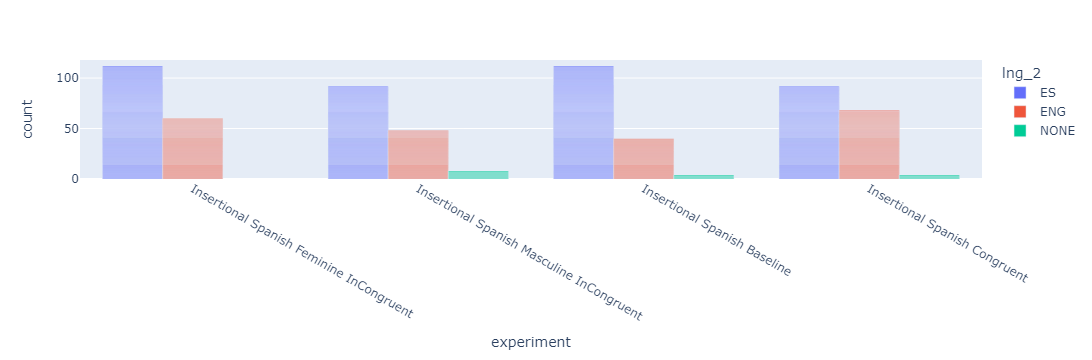

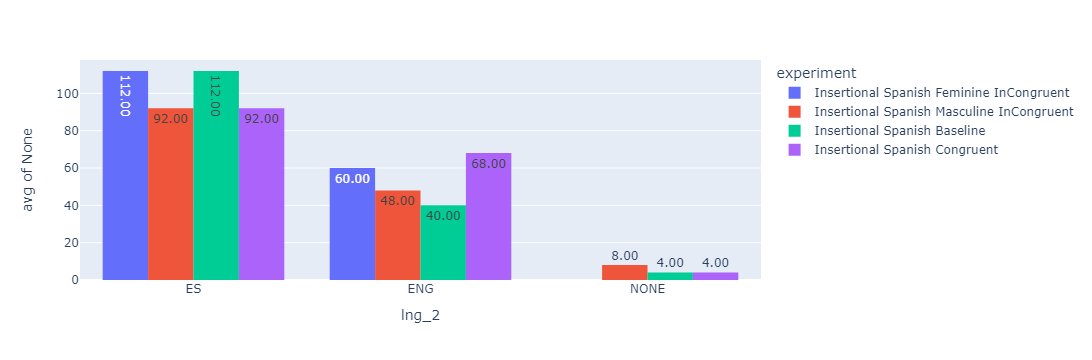

In [17]:
px.bar(df_copy,
             x='experiment',
             color='lng_2',
#                y='Q_enjoy',
               barmode="group"
            ).show()

px.histogram(df_copy,
             x='lng_2',
#              y='Q_enjoy',
             color='experiment',
             text_auto='.2f',
             histfunc='avg',
             barmode="group",
            ).show()
# px.bar(df_copy,
#              x='experiment',
#              color='lng_2',
#                barmode="group"
#             ).show()

Experiment comparison

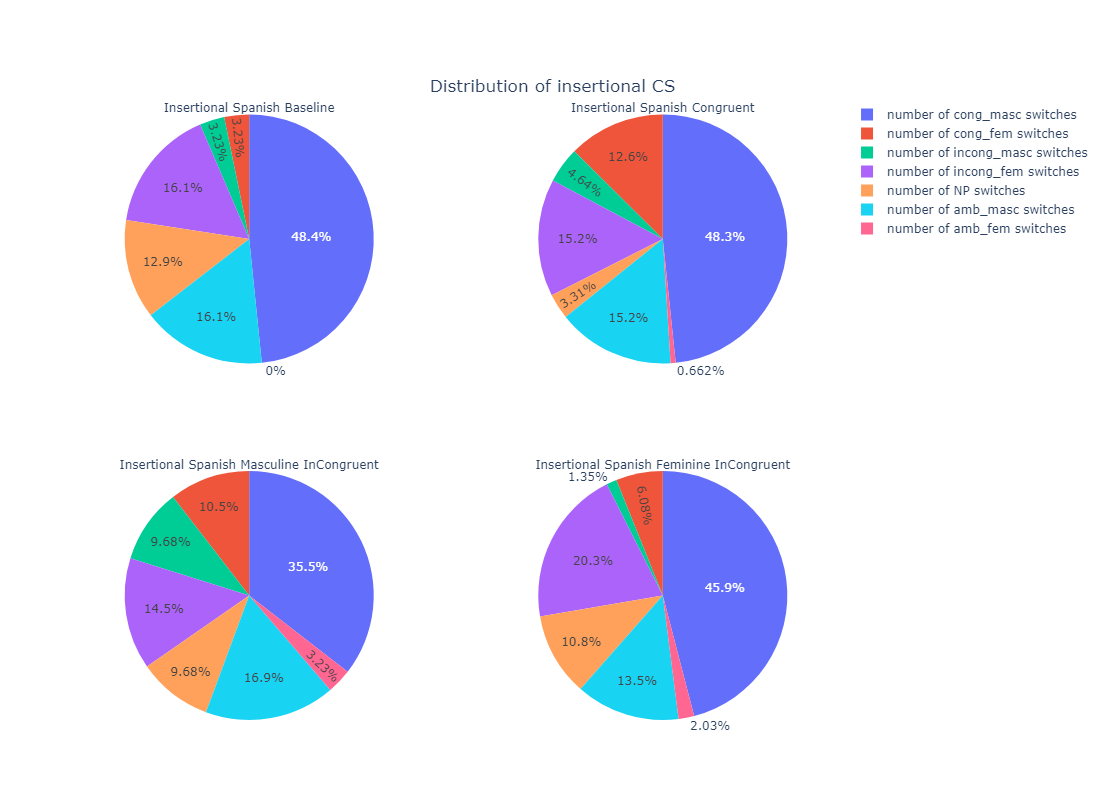

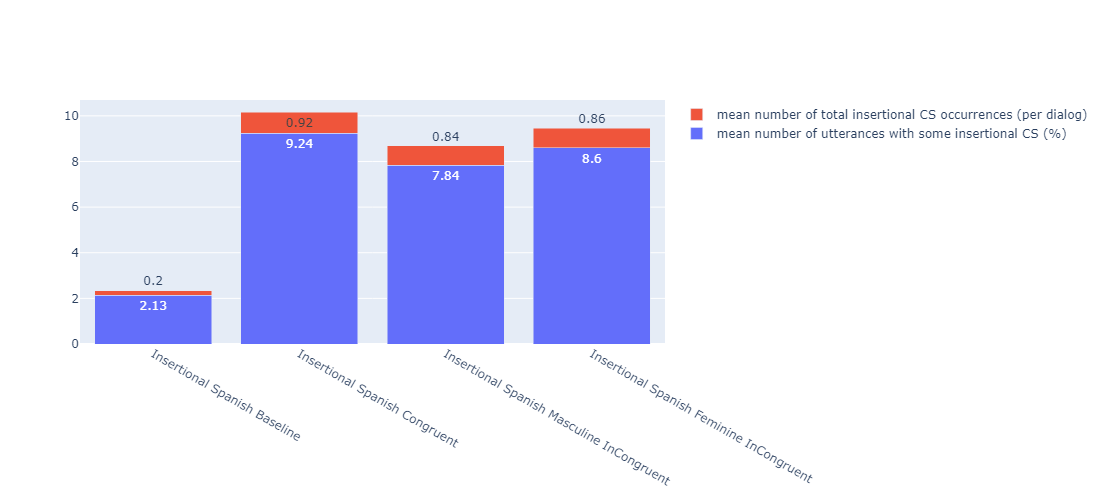

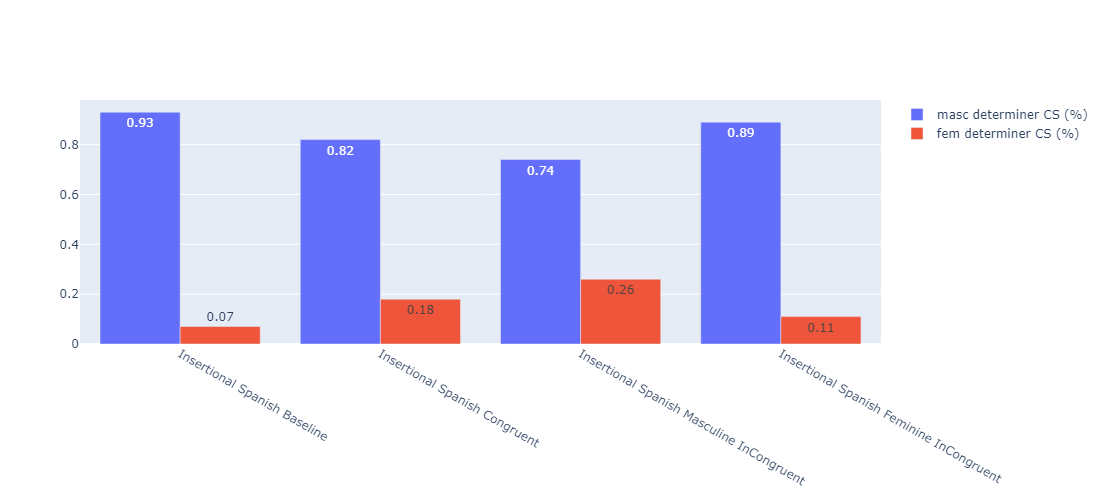

In [18]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math


def format_percentage(num: int) -> str:
    return round(num * 100, 2)

features=['user number of cong_masc switches',
          'user number of cong_fem switches',
          'user number of incong_masc switches', # incong 1
          'user number of incong_fem switches', # incong 2
          'user number of NP switches',
          'user number of amb_masc switches', 
          'user number of amb_fem switches']
pies=[]

mean_num_uter_w_cong_cs_normal_values = []
mean_num_of_total_cong_switch = []
masc_det = []
fem_det = []

for exp in experiments:
    exp_df = get_experiment_df([exp])
    exp_df = remove_rename_columns(exp_df)

    #bar plot
    mean_utters = np.mean(exp_df['user number of utterances'])
    mean_num_uter_w_cong_cs = np.mean(exp_df['user number of utterances with some ins switch'])
    mean_num_uter_w_cong_cs_normal_values.append(format_percentage(mean_num_uter_w_cong_cs / mean_utters))

    mean_num_of_total_cong_switch.append(round(np.mean(exp_df['user number of total ins switches']),2))

    total_det_cs = np.sum(exp_df['user number of masc det switches']) + np.sum(exp_df['user number of fem det switches'])
    
    masc_det.append(round(np.sum(exp_df['user number of masc det switches'])/total_det_cs,2))
    fem_det.append(round(np.sum(exp_df['user number of fem det switches'])/total_det_cs,2))

    # distribution of cong types
    means_ = {}
    for f in features:
        means_[f] = np.mean(exp_df[f]) / np.mean(exp_df['user number of total ins switches'])

    labels = list(means_.keys())
    labels = [l[5:] for l in labels]
    values = list(means_.values())
    pies.append(go.Pie(labels=labels,values=values, sort=False,title=exp))


rows = math.ceil(len(pies) /2)
specs = [[{"type": "domain"}, {"type": "domain"}]] * rows
opts = [(1,1), (1,2), (2,1), (2,2), (3,1)]
fig = make_subplots(
    rows=rows, cols=2,
    specs=specs,
)

for idx, p in enumerate(pies):
    row, col = opts[idx]
    fig.add_trace(p,row=row, col=col)

# fig.update_layout(height=800, width=800)
    fig.update_layout(
    width=900,
    height=800,
    title={
    'text': 'Distribution of insertional CS',
    'y':0.9,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
)
fig.show()

fig = go.Figure()
fig.add_trace(go.Bar(x=experiments,
                    name='mean number of utterances with some insertional CS (%)',
                    y=mean_num_uter_w_cong_cs_normal_values,
                    text=mean_num_uter_w_cong_cs_normal_values))
fig.add_trace(go.Bar(x=experiments,
                    name='mean number of total insertional CS occurrences (per dialog)',
                    y=mean_num_of_total_cong_switch,
                    text=mean_num_of_total_cong_switch))
fig.update_layout(barmode='stack',width=1000,height=500)
fig.show()

fig = go.Figure()
fig.add_trace(go.Bar(x=experiments,
                    name='masc determiner CS (%)',
                    y=masc_det,
                    text=masc_det))
fig.add_trace(go.Bar(x=experiments,
                    name='fem determiner CS (%)',
                    y=fem_det,
                    text=fem_det))
fig.update_layout(width=1000,height=500)
fig.show()


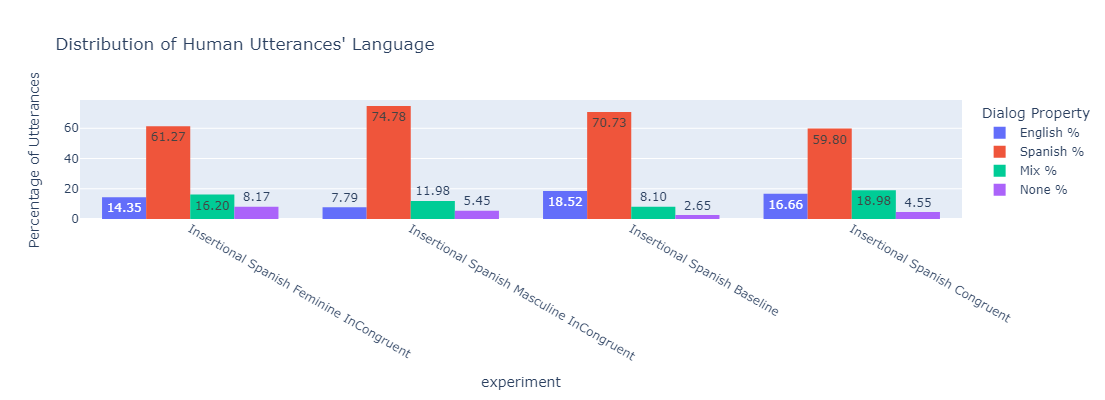

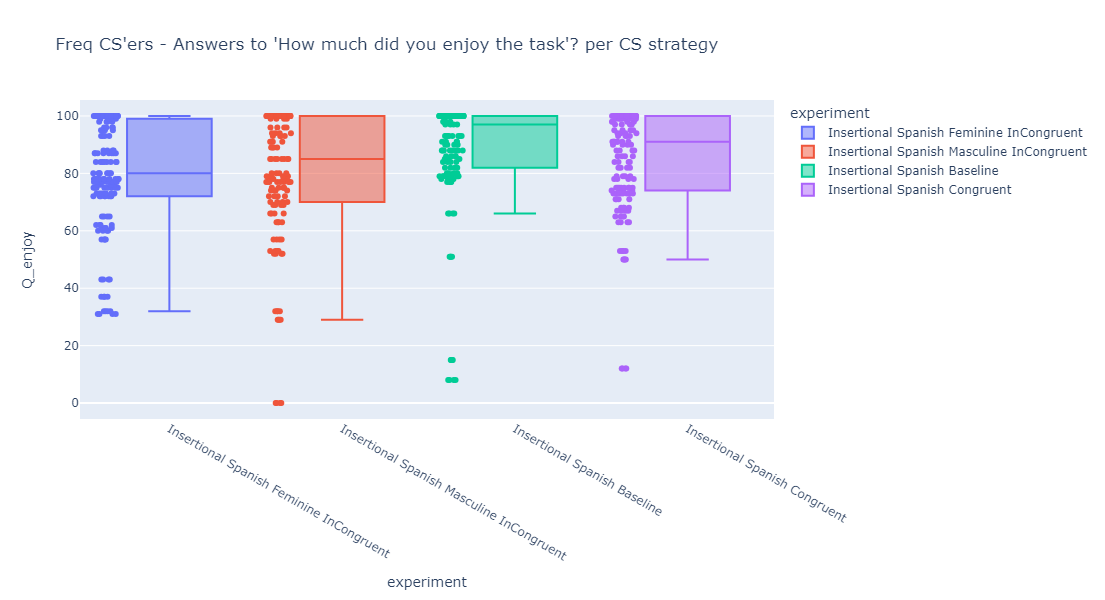

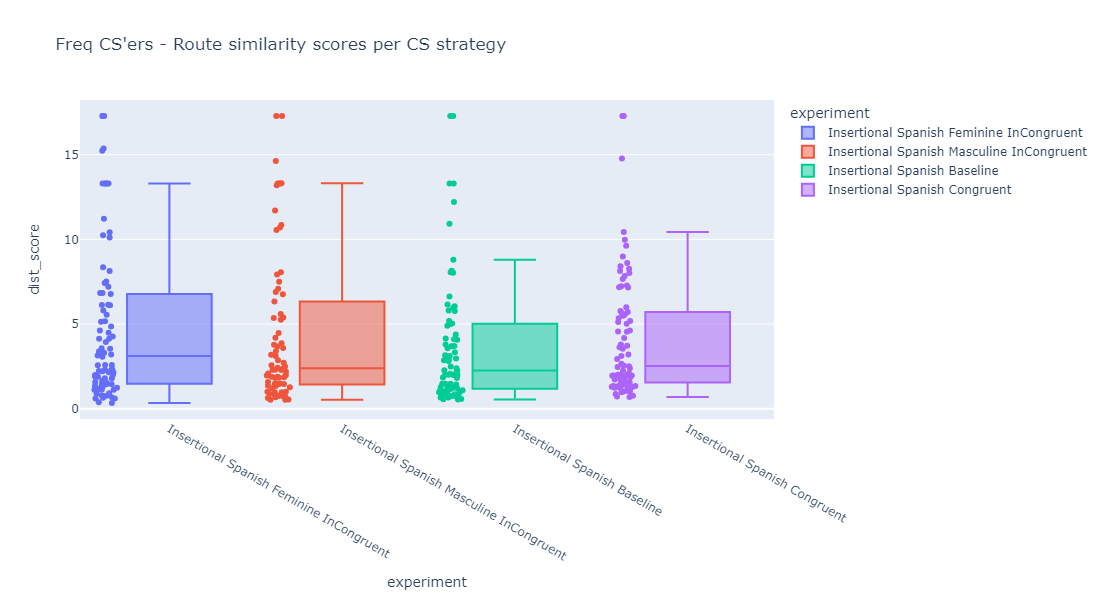

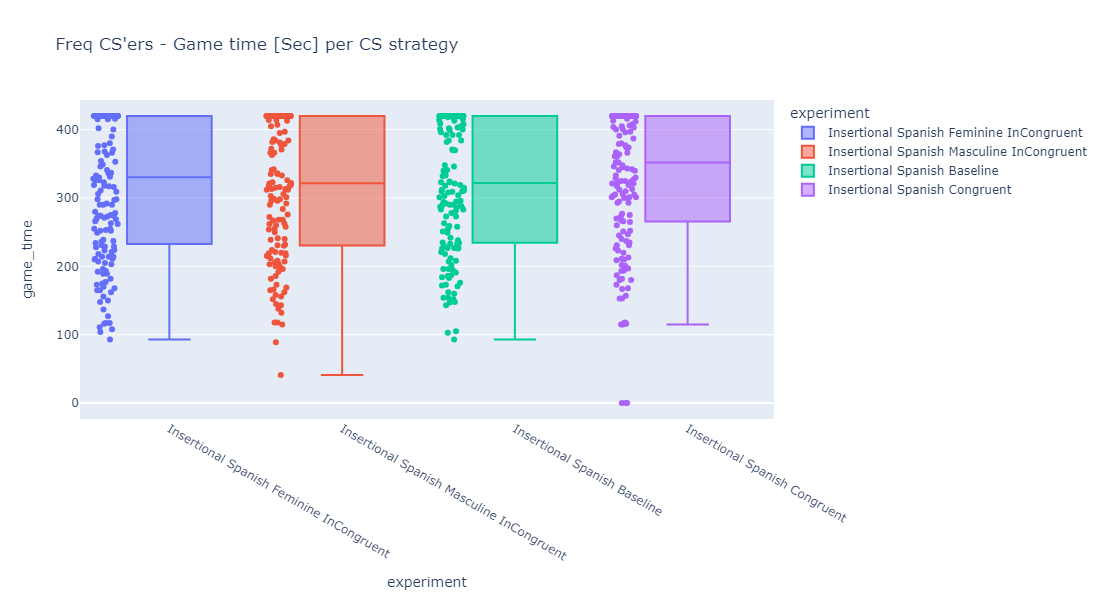

In [19]:
features=['English %', 'Spanish %', 'Mix %', 'None %'] # "Inter-Sentential CS %"]
fig = px.histogram(df_copy,
             x='experiment',
             y=features,
             text_auto='.2f',
             histfunc='avg',
             barmode="group",
             width=1000, height=400,
             title="Distribution of Human Utterances' Language",
            )

fig.update_layout(
    yaxis_title="Percentage of Utterances",
    legend_title="Dialog Property",
)
fig.show()

# features=["Inter-Sentential CS %"]
# fig = px.histogram(df_copy,
#              x='experiment',
#              y=features,
#              text_auto='.2f',
#              histfunc='avg',
#              barmode="group",
#              title="Inter-Sentential CS %",
#             )
# fig.show()


# if global_exp_ == 'ins':
#     features=['Q_successful', 'Q_enjoy', 'Q_enjoy_mix', 'Q_mix_friends', 'Q_mix_often', 'Q_natural']
# else:
#     features=['Q_successful', 'Q_enjoy', 'Q_enjoy_mix', 'Q_mix_friends']
# px.histogram(df_copy,
#              x='experiment',
#              y=features,
#              text_auto='.2f',
#              histfunc='avg',
#              barmode="group",
#             ).show()

# fig = px.box(df_copy,
#              x='experiment',
#              y="Inter-Sentential CS %",
#              points="all",
#              color='experiment',
#              title="Inter-Sentential CS (%) metric per CS strategy",
#             ).show()

# px.histogram(df_copy,
#              x='experiment',
#              y=['% entrainment - all dialog', '% entrainment - on bot inter-sentential cs'],
#              text_auto='.2f',
#              histfunc='avg',
#              barmode="group",
#             ).show()


# fig = px.box(df_copy,
#              x='experiment',
#              y='% entrainment - on bot inter-sentential cs',
#              points="all",
#              color='experiment',
#              title="Entrainment metric (on bot inter-sentential cs) per CS strategy",
#             ).show()

# fig = px.box(df_copy,
#              x='experiment',
#              y='% entrainment - all dialog',
#              points="all",
#              color='experiment',
#              title="Entrainment (overall) metric per CS strategy",
#             ).show()

fig = px.box(df_copy,
             x='experiment',
             y='Q_enjoy',
             points="all",
             color='experiment',
             title="Freq CS'ers - Answers to 'How much did you enjoy the task'? per CS strategy",
             width=1000, height=600
            ).show()

fig = px.box(df_copy,
             x='experiment',
             y='dist_score',
             points="all",
             color='experiment',
             title="Freq CS'ers - Route similarity scores per CS strategy",
             width=1000, height=600
            ).show()

fig = px.box(df_copy,
             x='experiment',
             y='game_time',
             points="all",
             color='experiment',
             title="Freq CS'ers - Game time [Sec] per CS strategy",
             width=1000, height=600
            ).show()
